In [1]:
from xcquinox import net
import optax
from xcquinox.train import Pretrainer_deriv

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Inputs from my notebooks that I need here
Compute the inputs with derivatives, and losses that take into account derivatives. Also, plotting functions.

In [9]:
# Imports
import jax
import jax.numpy as jnp
import jax.typing as jt
from xcquinox.utils import lda_x, PBE_Fx, pw92c_unpolarized_scalar, PBE_Fc
import equinox as eqx
from functools import partial
# Get references
def gtv_FX_grid_vgrho_dvsig(npts: int, s_lims: list[float], rho_lims: list[float],
                            separe_s: bool = False,
                            separe_s_val: float = 0.7, lim_s: float = 1.0,
                            erho=True, return_sigma=False) \
                            -> tuple:
    """Get the true values, gradients and the inputs for Fx.

    The gradients are computed wrt rho and sigma.
    rho, sigma = inputs
    TODO: DOC
    Args:
        erho (bool, optional): Wheher to derivate e*rho = e_{UEG}*Fx*rho.
        Defaults to True.
    Returns:
        tuple: grho_inputs, true_fx, true_fx_gradsig
            - grho_inputs: inputs for the model. rho, grad_rho = grho_inputs
            - true_fx: true values of Fx. Fx(rho, grad_rho)
            - true_fx_gradsig: true gradients of Fx. dFx/drho, dFx/dsigma
    """
    # Suggest values for the hyperparameters
    # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).
    NPTS = npts

    START_S, STOP_S = s_lims  # Adjust these values as needed
    START_RHO, STOP_RHO = rho_lims  # Range of rho values to test
    # Generate training data
    # Create more points for small values of s

    in_p = jnp.sqrt(NPTS)  # Input points
    if separe_s:
        s_values_low = jnp.linspace(START_S, lim_s,
                                    num=int(separe_s_val * in_p))
        s_values_high = jnp.linspace(lim_s, STOP_S,
                                     num=int(in_p)-int(separe_s_val * in_p))
        s_values = jnp.concatenate([s_values_low, s_values_high])
    else:
        #  Unbiased sampling
        s_values = jnp.linspace(START_S, STOP_S, num=int(in_p))

    rho_values = jnp.logspace(jnp.log10(START_RHO),
                              jnp.log10(STOP_RHO), num=int(in_p))

    rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
    rho_flat = rho_mesh.flatten()
    s_flat = s_mesh.flatten()
    # Calculate grad_rho
    k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
    grho_flat = (2 * s_flat * k_F * rho_flat)
    sigma_flat = grho_flat**2

    # Create input array
    grho_inputs = jnp.stack([rho_flat, grho_flat], axis=1)
    sig_inputs = jnp.stack([rho_flat, sigma_flat], axis=1)

    # Calculate true Fx
    true_fx = PBE_Fx(rho_flat, grho_flat, lower_rho_cutoff=0.0)
    if erho:
        def FxSIG_erho(rho, sigma):
            e_x_ueg = lda_x(rho)
            return FxSIG(rho, sigma) * rho * e_x_ueg
        true_fx_gradsig = jax.vmap(
            jax.grad(FxSIG_erho, argnums=(0, 1)))(rho_flat, sigma_flat)
    else:
        true_fx_gradsig = jax.vmap(
            jax.grad(FxSIG, argnums=(0, 1)))(rho_flat, sigma_flat)
    if return_sigma:
        return sig_inputs, true_fx, true_fx_gradsig
    else:
        return grho_inputs, true_fx, true_fx_gradsig


def gtv_FC_grid_vgrho_dvsig(npts: int, s_lims: list[float],
                            rho_lims: list[float],
                            separe_s: bool = False,
                            separe_s_val: float = 0.7, lim_s: float = 1.0,
                            erho=True, return_sigma=False) \
                            -> tuple:
    """Get the true values, gradients and the inputs for Fc.

    The gradients are computed wrt rho and sigma.
    rho, sigma = inputs
    TODO: DOC
    Args:
        erho (bool, optional): Wheher to derivate e*rho = e_{UEG}*Fc*rho.
            Defaults to True.
    Returns:
        tuple: grho_inputs, true_fc, true_fc_gradsig
            - grho_inputs: inputs for the model. rho, grad_rho = grho_inputs
            - true_fc: true values of Fc. Fc(rho, grad_rho)
            - true_fc_gradsig: true gradients of Fc. dFc/drho, dFc/dsigma
    """
    # Suggest values for the hyperparameters
    # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).
    NPTS = npts

    START_S, STOP_S = s_lims  # Adjust these values as needed
    START_RHO, STOP_RHO = rho_lims  # Range of rho values to test
    # Generate training data
    # Create more points for small values of s

    in_p = jnp.sqrt(NPTS)  # Input points
    if separe_s:
        s_values_low = jnp.linspace(START_S, lim_s,
                                    num=int(separe_s_val * in_p))
        s_values_high = jnp.linspace(lim_s, STOP_S,
                                     num=int(in_p)-int(separe_s_val * in_p))
        s_values = jnp.concatenate([s_values_low, s_values_high])
    else:
        #  Unbiased sampling
        s_values = jnp.linspace(START_S, STOP_S, num=int(in_p))

    rho_values = jnp.logspace(jnp.log10(START_RHO),
                              jnp.log10(STOP_RHO), num=int(in_p))

    rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
    rho_flat = rho_mesh.flatten()
    s_flat = s_mesh.flatten()
    # Calculate grad_rho
    k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
    grho_flat = (2 * s_flat * k_F * rho_flat)
    sigma_flat = grho_flat**2

    # Create input array
    grho_inputs = jnp.stack([rho_flat, grho_flat], axis=1)

    # Calculate true Fc
    true_fc = PBE_Fc(rho_flat, grho_flat)
    if erho:
        def FcSIG_erho(rho, sigma):
            e_x_ueg = pw92c_unpolarized_scalar(rho)
            return FcSIG(rho, sigma) * rho * e_x_ueg
        true_fc_gradsig = jax.vmap(
            jax.grad(FcSIG_erho, argnums=(0, 1)))(rho_flat, sigma_flat)
    else:
        true_fc_gradsig = jax.vmap(
            jax.grad(FcSIG, argnums=(0, 1)))(rho_flat, sigma_flat)
    if return_sigma:
        sig_inputs = jnp.stack([rho_flat, sigma_flat], axis=1)
        return sig_inputs, true_fc, true_fc_gradsig
    else:
        return grho_inputs, true_fc, true_fc_gradsig


@eqx.filter_value_and_grad
def loss_vg_erho_fxSIG(model, inputs, ref_v, ref_g):
    """ Model takes rho and sigma as inputs."""
    # Compute predicted values
    pred = jax.vmap(model)(inputs)
    # Compute predicted gradients of rho*e_ueg(rho)*model w.r.t. rho and sigma
    def e_rho_func(sigma_inputs):
        """ This has sigma a input, to derivate againts sigma"""
        rho, sigma = sigma_inputs
        return lda_x(rho) * rho * model(sigma_inputs)
    pred_grad_rho, pred_grad_sigma = \
        jax.vmap(partial(compute_derivatives, e_rho_func))(inputs)
    # ref_grad is a tuple, so we need to unpack it
    ref_grad_rho, ref_grad_sigma = ref_g

    # Compute MSE for function values and each derivative
    loss_values = jnp.mean((pred - ref_v) ** 2)
    loss_grad_rho = jnp.mean((pred_grad_rho - ref_grad_rho) ** 2)
    loss_grad_grad_rho = jnp.mean((pred_grad_sigma - ref_grad_sigma) ** 2)

    # Combine losses
    total_loss = loss_values + loss_grad_rho + loss_grad_grad_rho

    return total_loss


@eqx.filter_value_and_grad
def loss_vg_erho_fcSIG(model, inputs, ref_v, ref_g):
    """ Model takes rho and sigma as inputs."""
    # Compute predicted values
    pred = jax.vmap(model)(inputs)
    inputs = jnp.atleast_1d(inputs)  # Ensure inputs is at least 1D

    # Compute predicted gradients of rho*e_ueg(rho)*model w.r.t. rho and sigma
    def e_rho_func(sigma_inputs):
        """ This has sigma a input, to derivate againts sigma"""
        rho, sigma = sigma_inputs
        return pw92c_unpolarized_scalar(rho) * rho * model(sigma_inputs)
    pred_grad_rho, pred_grad_sigma = \
        jax.vmap(partial(compute_derivatives, e_rho_func))(inputs)
    # ref_grad is a tuple, so we need to unpack it
    ref_grad_rho, ref_grad_sigma = ref_g

    # Compute MSE for function values and each derivative
    loss_values = jnp.mean((pred - ref_v) ** 2)
    loss_grad_rho = jnp.mean((pred_grad_rho - ref_grad_rho) ** 2)
    loss_grad_grad_rho = jnp.mean((pred_grad_sigma - ref_grad_sigma) ** 2)

    # Combine losses
    total_loss = loss_values + loss_grad_rho + loss_grad_grad_rho

    return total_loss


def FxSIG(rho: jt.ArrayLike, sigma: jt.ArrayLike) -> jt.ArrayLike:
    """Exact reference exchange enhancement factor.

    As a function of n and sigma.
    Args:
        rho (jt.ArrayLike): 
        sigma (jt.ArrayLike):

    Returns:
        jt.ArrayLike: Fx
    """
    kf = (3 * jnp.pi**2 * rho)**(1/3)
    s = jnp.sqrt(sigma)/(2*kf*rho)
    kappa, mu = 0.804, 0.21951
    # Exchange enhancement factor
    Fx = 1 + kappa - kappa / (1 + mu * s**2 / kappa)

    return Fx

def FcSIG(rho: jt.ArrayLike, sigma: jt.ArrayLike) -> jt.ArrayLike:
    """Exact reference correlation enhancement function, as a function of sigma
    TODO DOC"""

    grad_rho = jnp.sqrt(sigma)
    pi = jnp.pi
    k_F = (3 * pi**2 * rho)**(1/3)
    k_s = jnp.sqrt((4 * k_F) / pi)
    t = jnp.abs(grad_rho) / (2 * k_s * rho)
    beta = 0.066725
    gamma = (1 - jnp.log(2)) / (pi**2)

    # Use pw92c_unpolarized for e_heg_c
    e_heg_c = pw92c_unpolarized_scalar(rho)

    A = (beta / gamma) / (jnp.exp(-e_heg_c / (gamma)) - 1)

    H = gamma * jnp.log(1 + (beta / gamma) * t**2 *
                        ((1 + A * t**2) / (1 + A * t**2 + A**2 * t**4)))

    Fc = 1 + (H / e_heg_c)  # correlation enhancement factor

    return Fc


@eqx.filter_jit
def compute_derivatives(model, inputs):
    """Compute gradient w.r.t. both components (rho and grad_rho)

    rho = inputs[0]
    grad_rho = inputs[1]
    """

    # x is the value wrt we derivate.
    grad_rho = jax.grad(lambda x:
                        model(jnp.array([x, inputs[1]])))(inputs[0])
    grad_grad_rho = jax.grad(lambda x:
                             model(jnp.array([inputs[0], x])))(inputs[1])
    return (grad_rho, grad_grad_rho)


In [3]:
from typing import Callable, Union
import matplotlib.pyplot as plt
import numpy as np
# Plots

def plot_testinf_fxSIG_s(model_fx: Callable[[jt.ArrayLike, jt.ArrayLike],
                                            jt.ArrayLike],
                         start_s: float = 1e-5, stop_s: float = 5.0,
                         save: bool = False, figname: str = 'fx_Sig.png',
                         title: Union[str, None] = None, rho: float = 1.0):
    """Plot Fx vs s with gradients.

    The input that the network expects are rho and sigma, so the derivatives
    are taken with respect to these two variables (creo).

    Args:
        model_fx (Callable[[jt.ArrayLike, jt.ArrayLike]]): trained function for
            the exchange enhancement factor.
        start_s (float, optional): Start of the interval for the test s values.
            Defaults to 0.0
        stop_s (float, optional): End of the interval for the test s values.
            Defaults to 5.0
        save (bool, optional): Whether to save the output image.
            Defaults to False
        figname (str, optional): In case of saving the image, the name of this.
            Defaults to 'fxs.png'
        title (Union[str, None], optional): Title to put to the plot. If None,
            no title. Defaults to None
        rho (float, optional): constant rho value. Defaults to 1.0

    Returns:
        None
    """
    # Generate test points
    test_s = jnp.linspace(start_s, stop_s, num=1000)
    test_rho = jnp.full_like(test_s, rho)  # Constant rho for simplicity

    # Calculate grad_rho for the test points
    k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
    sigma_test = (2 * test_s * k_F_test * test_rho)**2

    # Prepare inputs for the neural networks
    test_inputs = jnp.stack([test_rho, sigma_test], axis=1)

    # Calculate true PBE enhancement factors
    true_fx_test = FxSIG(test_rho, sigma_test)

    # Predict using neural networks
    pred_fx = jax.vmap(model_fx)(test_inputs).squeeze()

    def scalar_Fx(rho, sigma):
        return FxSIG(jnp.array([rho]), jnp.array([sigma]))[0]

    # Compute gradients
    grad_Fx = jax.vmap(jax.grad(scalar_Fx, argnums=(0, 1)))
    true_fx_grad_rho, true_fx_grad_sigma = \
        grad_Fx(test_rho.flatten(), sigma_test.flatten())
    pred_grad_rho_fx, pred_grad_sigma_fx = \
        jax.vmap(partial(compute_derivatives, model_fx))(test_inputs)

    __do_derivatives_plot(test_s, true_fx_test, pred_fx,
                          true_fx_grad_rho, pred_grad_rho_fx,
                          true_fx_grad_sigma, pred_grad_sigma_fx,
                          save=save, figname=figname, title=title, model='Fx',
                          xlabel='s')
def plot_testinf_fcSIG_s(model_fc: Callable[[jt.ArrayLike, jt.ArrayLike],
                                            jt.ArrayLike],
                         start_s: float = 1e-5, stop_s: float = 5.0,
                         save: bool = False, figname: str = 'fc_Sig.png',
                         title: Union[str, None] = None, rho: float = 1.0):
    """Plot Fc vs s with gradients.

    The input that the network expects are rho and sigma, so the derivatives
    are taken with respect to these two variables (creo).

    Args:
        model_fc (Callable[[jt.ArrayLike, jt.ArrayLike]]): trained function for
            the exchange enhancement factor.
        start_s (float, optional): Start of the interval for the test s values.
            Defaults to 0.0
        stop_s (float, optional): End of the interval for the test s values.
            Defaults to 5.0
        save (bool, optional): Whether to save the output image.
            Defaults to False
        figname (str, optional): In case of saving the image, the name of this.
            Defaults to 'fcs.png'
        title (Union[str, None], optional): Title to put to the plot. If None,
            no title. Defaults to None
        rho (float, optional): constant rho value. Defaults to 1.0

    Returns:
        None
    """
    # Generate test points
    test_s = jnp.linspace(start_s, stop_s, num=1000)
    test_rho = jnp.full_like(test_s, rho)  # Constant rho for simplicity

    # Calculate grad_rho for the test points
    k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
    sigma_test = (2 * test_s * k_F_test * test_rho)**2

    # Prepare inputs for the neural networks
    test_inputs = jnp.stack([test_rho, sigma_test], axis=1)

    # Calculate true PBE enhancement factors
    true_fc_test = FcSIG(test_rho, sigma_test)

    # Predict using neural networks
    pred_fc = jax.vmap(model_fc)(test_inputs).squeeze()

    def scalar_Fc(rho, sigma):
        return FcSIG(jnp.array([rho]), jnp.array([sigma]))[0]

    # Compute gradients
    grad_Fc = jax.vmap(jax.grad(scalar_Fc, argnums=(0, 1)))
    true_fc_grad_rho, true_fc_grad_sigma = \
        grad_Fc(test_rho.flatten(), sigma_test.flatten())
    pred_grad_rho_fc, pred_grad_sigma_fc = \
        jax.vmap(partial(compute_derivatives, model_fc))(test_inputs)

    __do_derivatives_plot(test_s, true_fc_test, pred_fc,
                          true_fc_grad_rho, pred_grad_rho_fc,
                          true_fc_grad_sigma, pred_grad_sigma_fc,
                          save=save, figname=figname, title=title, model='Fc',
                          xlabel='s')


def __do_derivatives_plot(test_points: jt.ArrayLike, true_F: jt.ArrayLike,
                          pred_F: jt.ArrayLike,
                          true_F_grad_rho: jt.ArrayLike,
                          pred_F_grad_rho: jt.ArrayLike,
                          true_F_grad_grad_rho: jt.ArrayLike,
                          pred_F_grad_grad_rho: jt.ArrayLike,
                          save: bool = False, figname: str = 'dplot.png',
                          title: Union[str, None] = None, model: str = 'F',
                          xlabel: str = 'Unknown'):
    """
    Creates a plot of derivatives for a given model.

    Args:
        test_points (jt.ArrayLike): points where the model was tested.
        true_F (jt.ArrayLike): true values of the model (F).
        pred_F (jt.ArrayLike): predicted values of the model (F).
        true_F_grad_rho (jt.ArrayLike): true gradient of F wrt rho.
        pred_F_grad_rho (jt.ArrayLike): predicted gradient of F wrt rho.
        true_F_grad_grad_rho (jt.ArrayLike): true gradient of F wrt
            the gradient of rho.
        pred_F_grad_grad_rho (jt.ArrayLike): predicted gradient of F wrt
            the gradient of rho.
        save (bool, optional): Whether to save the output image.
            Defaults to False
        figname (str, optional): In case of saving the image, the name of this.
            Defaults to 'dplot.png'
        title (Union[str, None], optional): Title to put to the plot. If None,
            no title. Defaults to None
        model (str, optional): Which model we are plottig (serves to specify
            Fx or Fc to have the labels correctly). Defaults to 'F'
        xlabel (str, optional): label for the x-axis. It is used to specify
            if we are plotting agains rho or s. Defaults to 'Unknown'

    Returns:
        None
    """
    # Calculate statistics
    r2_fc, mae_fc, rmse_fc = calculate_stats(true_F, pred_F)
    r2_gfc, mae_gfc, rmse_gfc = calculate_stats(true_F_grad_rho,
                                                pred_F_grad_rho)
    r2_ggfc, mae_ggfc, rmse_ggfc = calculate_stats(true_F_grad_grad_rho,
                                                   pred_F_grad_grad_rho)
    m = model
    x = xlabel

    # 1. Correlation plots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    if title is not None:
        fig.suptitle(f'{title}')

    ax1, ax2, ax3 = axes[0, :]
    ax1.scatter(true_F, pred_F, alpha=0.5)
    ax1.plot([true_F.min(), true_F.max()],
             [true_F.min(), true_F.max()], 'r--')
    ax1.set_xlabel(f'True {m}')
    ax1.set_ylabel(f'Predicted {m}')
    ax1.set_title(f'''True vs Predicted {m}\nR² = {r2_fc:.4f},
    MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}''')

    ax2.scatter(true_F_grad_rho, pred_F_grad_rho, alpha=0.5)
    ax2.plot([true_F_grad_rho.min(), true_F_grad_rho.max()],
             [true_F_grad_rho.min(), true_F_grad_rho.max()], 'r--')
    ax2.set_xlabel(fr'True $\delta${m}/$\delta$n')
    ax2.set_ylabel(fr'Predicted $\delta${m}/$\delta$n')
    ax2.set_title(f'''True vs Predicted $\delta${m}/$\delta$n
                  R² = {r2_gfc:.4f},
    MAE = {mae_gfc:.4f}, RMSE = {rmse_gfc:.4f}''')

    ax3.scatter(true_F_grad_grad_rho, pred_F_grad_grad_rho, alpha=0.5)
    ax3.plot([true_F_grad_grad_rho.min(), true_F_grad_grad_rho.max()],
             [true_F_grad_grad_rho.min(), true_F_grad_grad_rho.max()], 'r--')
    ax3.set_xlabel(fr'True $\delta${m}/$\delta$($\nabla$n)')
    ax3.set_ylabel(fr'Predicted $\delta${m}/$\delta$($\nabla$n)')
    text = (fr'True vs Predicted $\delta${m}/$\delta\nabla$(n)'
            f'''\nR² = {r2_ggfc:.4f},
            MAE = {mae_ggfc:.4f}, RMSE = {rmse_ggfc:.4f}''')
    ax3.set_title(text)

    # 2. True PBE factors vs. xlabel (the one given)

    ax1, ax2, ax3 = axes[1, :]
    ax1.plot(test_points, true_F, label=f'True {m}')
    ax1.plot(test_points, pred_F, label=f'Predicted {m}')
    ax1.set_xlabel(f'{x}')
    ax1.set_ylabel(f'{m}')
    ax1.set_title(f'''{m} vs {x}\nR² = {r2_fc:.4f},
    MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}''')
    ax1.legend()

    ax2.plot(test_points, true_F_grad_rho,
             label=fr'True $\delta${m}/$\delta$n')
    ax2.plot(test_points, pred_F_grad_rho,
             label=fr'Predicted $\delta${m}/$\delta$n')
    ax2.set_xlabel(f'{x}')
    ax2.set_ylabel(fr'$\delta${m}/$\delta$n')
    ax2.set_title(f'''$\delta${m}/$\delta$n vs {x}\nR² = {r2_gfc:.4f},
    MAE = {mae_gfc:.4f}, RMSE = {rmse_gfc:.4f}''')
    ax2.legend()

    ax3.plot(test_points, true_F_grad_grad_rho,
             label=fr'True $\delta${m}/$\delta$($\nabla$n)')
    ax3.plot(test_points, pred_F_grad_grad_rho,
             label=fr'Predicted $\delta${m}/$\delta$($\nabla$n)')
    ax3.set_xlabel(f'{x}')
    ax3.set_ylabel(fr'$\delta${m}/$\delta$($\nabla$n)')
    text = (fr'$\delta${m}/$\delta$($\nabla$n) vs {x}' +
            f'''\nR² = {r2_ggfc:.4f},\n MAE = {mae_ggfc:.4f},
            RMSE = {rmse_ggfc:.4f}''')
    ax3.set_title(text)
    ax3.legend()

    # 3. Error plots
    ax1, ax2, ax3 = axes[2, :]

    ax1.plot(test_points, np.abs(true_F - pred_F))
    ax1.set_xlabel(f'{x}')
    ax1.set_ylabel('Absolute Error')
    ax1.set_title(f'Absolute Error for {m} vs {x}')

    ax2.plot(test_points, np.abs(true_F_grad_rho - pred_F_grad_rho))
    ax2.set_xlabel(f'{x}')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title(fr'Absolute Error for $\delta${m}/$\delta$n vs {x}')

    ax3.plot(test_points, np.abs(true_F_grad_grad_rho - pred_F_grad_grad_rho))
    ax3.set_xlabel(f'{x}')
    ax3.set_ylabel('Absolute Error')
    ax3.set_title(fr'Abs. Error for $\delta${m}/$\delta$($\nabla$n) vs {x}')
    if x.lower() == 'rho':
        for i in [1, 2]:
            for j in range(3):
                axes[i, j].set_xscale('log')
    plt.tight_layout()
    if save:
        plt.savefig(figname, dpi=100)
    plt.show()

    # Print statistics
    print(f"\n{m} Statistics:")
    print(f"R-squared: {r2_fc:.6f}")
    print(f"Mean Absolute Error: {mae_fc:.6f}")
    print(f"Root Mean Squared Error: {rmse_fc:.6f}")
    print(f"""Maximum Absolute Error:
          {np.max(np.abs(true_F - pred_F)):.6f}""")

def calculate_stats(true: jt.ArrayLike, pred: jt.ArrayLike) -> \
        tuple:
    """Calculate statistics of the model

    Compares the array "true" and "pred" and gives:
    - R-squared value
    - Mean Absolute Error
    - Root Mean Squared Error

    To be used to compute the statistics between the output
    of a NN and the expected values.
    Args:
        true (jt.ArrayLike): True values
        pred (jt.ArrayLike): Predicted values

    Returns:
        tuple: A tuple containing:
            - r2 (float): R-squared value
            - mae (float): Mean Absolute Error
            - rmse (float): Root Mean Squared Error
    """
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))

    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))

    return r2, mae, rmse

## Create and train the networks

In [4]:
fx_variables = {'depth': 3, 'nodes': 16, 'seed': 42}
fc_variables = {'depth': 3, 'nodes': 16, 'seed': 42}


In [5]:
fx_net_SIG = net.GGA_FxNet_sigma(**fx_variables)
fc_net_SIG = net.GGA_FcNet_sigma(**fc_variables)

In [6]:
rho_lims = s_lims = [0.01, 5]
NPTS = 30000
# Get the inputs values for rho, grad_rho; and the true values of fx and fc
inputs, true_fx, true_fx_grad = gtv_FX_grid_vgrho_dvsig(npts=NPTS, s_lims=s_lims, rho_lims=rho_lims,
                                                        separe_s=True, separe_s_val=0.7, lim_s=0.5,
                                                        erho=True, return_sigma=True)
inputs, true_fc, true_fc_grad = gtv_FC_grid_vgrho_dvsig(npts=NPTS, s_lims=s_lims, rho_lims=rho_lims,
                                                        separe_s=True, separe_s_val=0.7, lim_s=0.5,
                                                        erho=True, return_sigma=True)

grad_rho, grad_sig = true_fx_grad
ref_with_grad_fx = jnp.stack([true_fx, grad_rho, grad_sig], axis=1)

grad_rho, grad_sig = true_fc_grad
ref_with_grad_fc = jnp.stack([true_fc, grad_rho, grad_sig], axis=1)
# Create optimizers
optimizer_fx = optax.adam(learning_rate=1e-3)
optimizer_fc = optax.adam(learning_rate=1e-3)

N_EPOCHS_MAX = 15000

In [7]:
fx_pt = Pretrainer_deriv(fx_net_SIG, optimizer_fx, inputs, ref_with_grad_fx, loss_vg_erho_fxSIG,
                   steps=N_EPOCHS_MAX, print_every=100)

Pretrainer prepared to train using values and gradients


In [8]:
fx_model, fx_losses = fx_pt()

Epoch 0: Loss = 0.44117668543486704
Epoch 100: Loss = 0.0014875283229562797
Epoch 200: Loss = 0.00021427544101965817
Epoch 300: Loss = 0.00014570596490641328
Epoch 400: Loss = 0.00010631745478462855
Epoch 500: Loss = 8.168580028665731e-05
Epoch 600: Loss = 6.617682483100208e-05
Epoch 700: Loss = 5.5116936546150614e-05
Epoch 800: Loss = 4.5909386292500934e-05
Epoch 900: Loss = 3.759836979768201e-05
Epoch 1000: Loss = 3.0081048013757743e-05
Epoch 1100: Loss = 2.3529105186628743e-05
Epoch 1200: Loss = 1.8030587192406052e-05
Epoch 1300: Loss = 1.3552584954419031e-05
Epoch 1400: Loss = 1.0067692060437759e-05
Epoch 1500: Loss = 7.563447097749353e-06
Epoch 1600: Loss = 5.928016260169473e-06
Epoch 1700: Loss = 4.918174186644595e-06
Epoch 1800: Loss = 4.2869244152892666e-06
Epoch 1900: Loss = 3.8735218837373965e-06
Epoch 2000: Loss = 3.5910564656124774e-06
Epoch 2100: Loss = 3.3911835202702083e-06
Epoch 2200: Loss = 3.244094435623227e-06
Epoch 2300: Loss = 3.130305457760047e-06
Epoch 2400: Loss

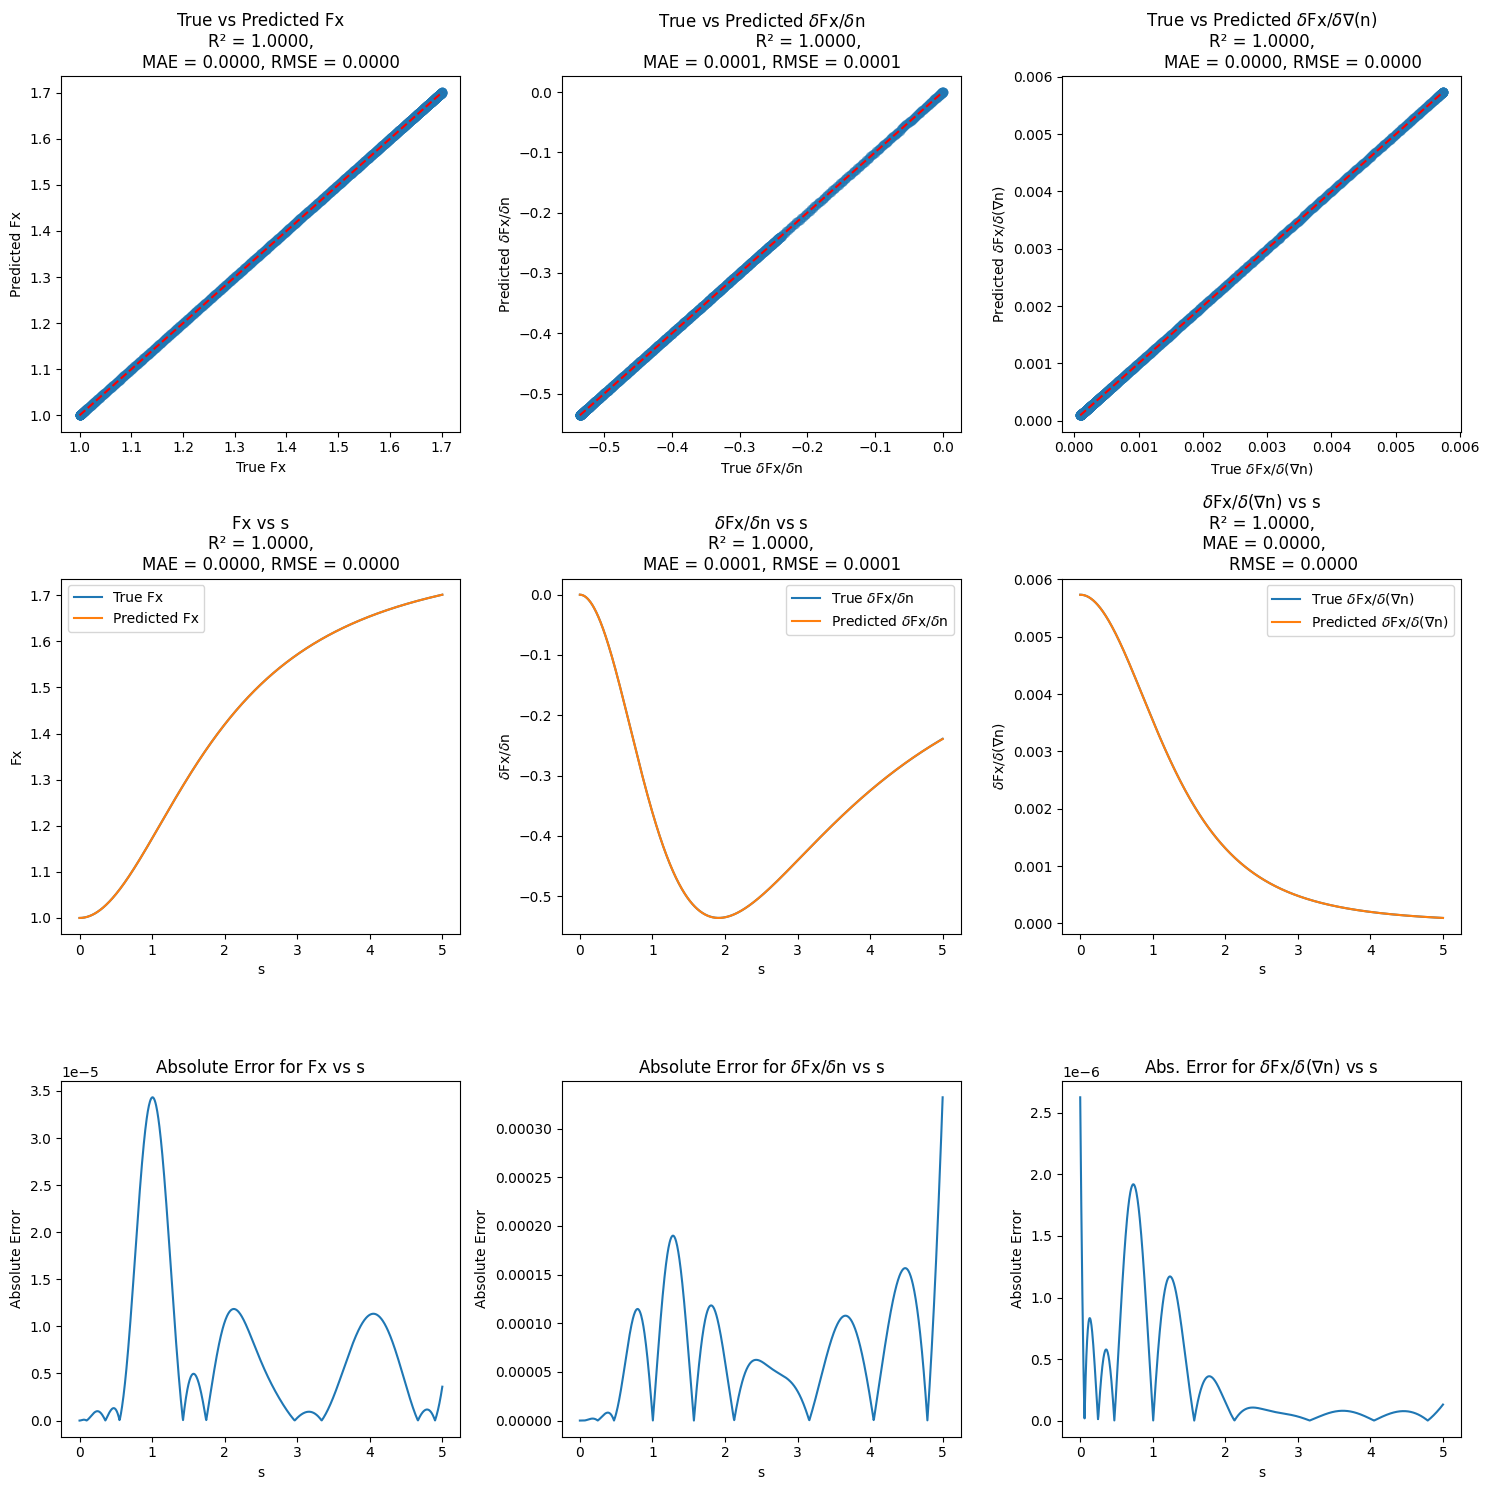


Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000007
Root Mean Squared Error: 0.000011
Maximum Absolute Error:
          0.000034


In [9]:
plot_testinf_fxSIG_s(fx_model)

In [10]:
fc_pt = Pretrainer_deriv(fc_net_SIG, optimizer_fc, inputs, ref_with_grad_fc, loss_vg_erho_fcSIG,
                   steps=N_EPOCHS_MAX, print_every=100)

Pretrainer prepared to train using values and gradients


In [11]:
fc_model, fc_losses = fc_pt()

Epoch 0: Loss = 0.3405164551409443
Epoch 100: Loss = 0.06582400007802423
Epoch 200: Loss = 0.0016412866328474318
Epoch 300: Loss = 0.0014974641809511516
Epoch 400: Loss = 0.0014216696880507227
Epoch 500: Loss = 0.0013587706228115955
Epoch 600: Loss = 0.0012959685788103182
Epoch 700: Loss = 0.001229423552703713
Epoch 800: Loss = 0.0011579650299364205
Epoch 900: Loss = 0.0010816712249819677
Epoch 1000: Loss = 0.0010015163462198714
Epoch 1100: Loss = 0.0009194431400796049
Epoch 1200: Loss = 0.0008383178445127476
Epoch 1300: Loss = 0.0007610852752310053
Epoch 1400: Loss = 0.0006896068721381618
Epoch 1500: Loss = 0.0006245026213097778
Epoch 1600: Loss = 0.0005659379213209096
Epoch 1700: Loss = 0.0005143769421382541
Epoch 1800: Loss = 0.00047059623888300695
Epoch 1900: Loss = 0.00043456416871300317
Epoch 2000: Loss = 0.00040427720854529906
Epoch 2100: Loss = 0.000376864771189222
Epoch 2200: Loss = 0.0003505993514438
Epoch 2300: Loss = 0.00032498859636919704
Epoch 2400: Loss = 0.0002998698746

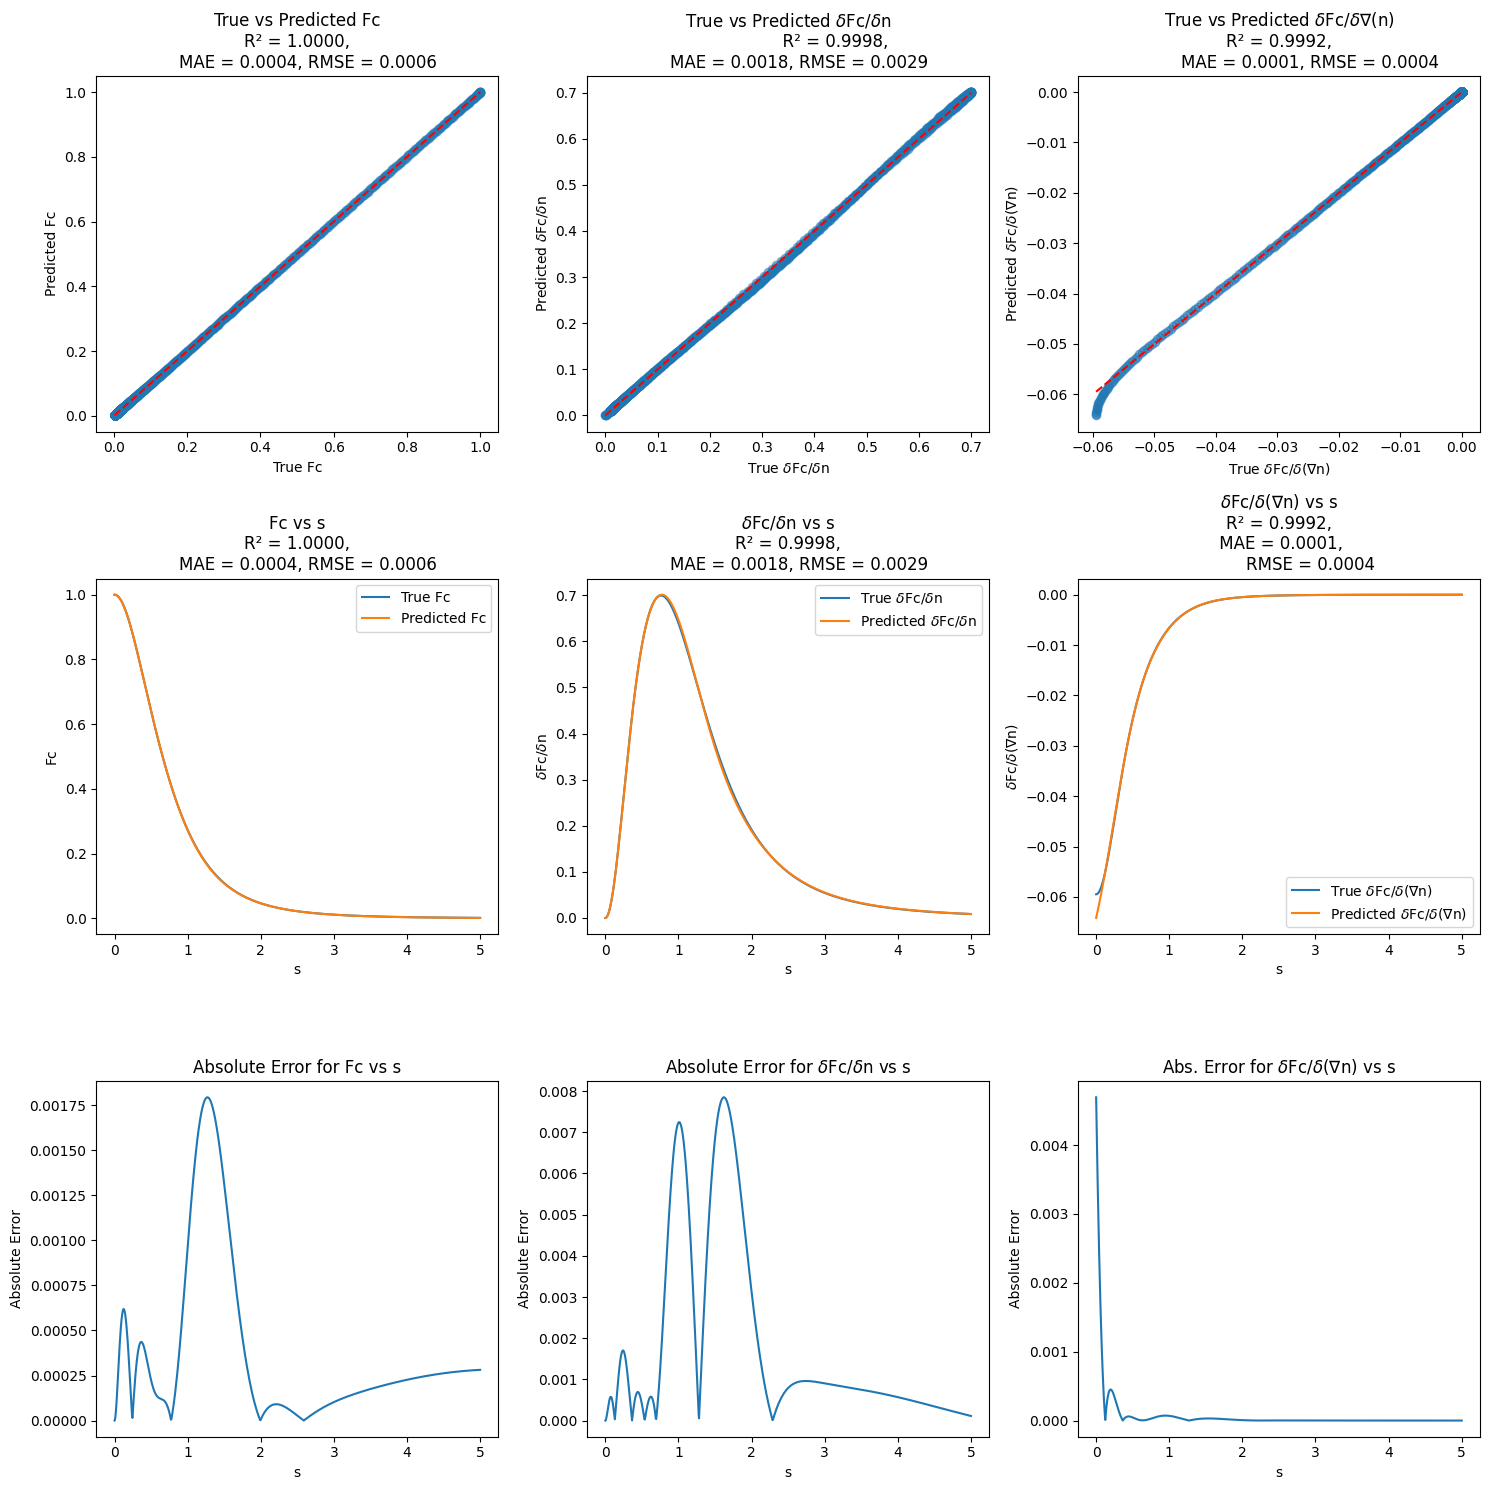


Fc Statistics:
R-squared: 0.999995
Mean Absolute Error: 0.000365
Root Mean Squared Error: 0.000582
Maximum Absolute Error:
          0.001794


In [12]:
plot_testinf_fcSIG_s(fc_model)

## Test that Alec's previous networks continue working with "Pretrainer_deriv"
Code copied from "pbe_notebook_v4.ipynb"

In [13]:
from xcquinox.utils import gen_grid_s, PBE_Fc

In [14]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

In [15]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [16]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

sinputs = jnp.stack([trf, tsf], axis=1)
siginputs = jnp.stack([strf, stgrf], axis=1)
sval = jnp.stack([vrf, vsf], axis=1)
print(sval.shape, sinputs.shape)

(3844, 2) (64009, 2)


In [17]:
from xcquinox.loss import compute_loss_mae
#create optimizers
soptimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)
spt_pbe_fx = Pretrainer_deriv(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc = Pretrainer_deriv(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)


Pretrainer prepared to train using values
Pretrainer prepared to train using values


In [18]:
snmx, snlx = spt_pbe_fx()
snmc, snlc = spt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.001767185656495253
Epoch 200: Loss = 0.0003965925629766827
Epoch 300: Loss = 0.0002891233052268366
Epoch 400: Loss = 0.00016220979333160483
Epoch 500: Loss = 0.0004153561510694539
Epoch 600: Loss = 0.00030480704476934484
Epoch 700: Loss = 0.00017691502797182883
Epoch 800: Loss = 8.416372507587452e-05
Epoch 900: Loss = 0.00042248722558047816
Epoch 1000: Loss = 0.0001188910551579722
Epoch 1100: Loss = 7.404514466943702e-05
Epoch 1200: Loss = 0.0002812912746333294
Epoch 1300: Loss = 0.0005135179035251922
Epoch 1400: Loss = 0.00010445190975950438
Epoch 1500: Loss = 0.0003308283695002126
Epoch 1600: Loss = 7.51739172698043e-05
Epoch 1700: Loss = 0.0003138221200721593
Epoch 1800: Loss = 0.000709819492560341
Epoch 1900: Loss = 0.00042569768777568303
Epoch 2000: Loss = 0.0002733275062483645
Epoch 2100: Loss = 0.0003532146246426631
Epoch 2200: Loss = 0.0003858761748142734
Epoch 2300: Loss = 0.00021954711246018
Epoch 2400: Loss = 0.00039701

Thereforem we demostrate that the pretrainer_deriv works for both.